In [ ]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

from kid_readout.measurement import basic, plot_basic
from kid_readout.measurement.io import npy
from kid_readout.analysis.resonator import lmfit_resonator

In [36]:
save_directory = '/home/flanigan/temp/'
save_example_eccosorb_response_sweeps = True
save_all_eccosorb_response = True

In [3]:
npd_3K = npy.NumpyDirectory('/data/readout/2017-12-05_130953_mmw.npd/')  # Same attenuations and bath temperature as 5 K
npd_5Ka = npy.NumpyDirectory('/data/readout/2017-12-04_145404_mmw_eccosorb.npd/')
npd_5Kb = npy.NumpyDirectory('/data/readout/2017-12-04_170628_mmw_eccosorb.npd/')

In [4]:
npd_3K.node_names()

['SweepStreamList0',
 'ADCSnap1',
 'SweepStreamList2',
 'ADCSnap3',
 'SweepStreamList4',
 'ADCSnap5',
 'SweepStreamList6',
 'ADCSnap7',
 'SweepStreamList8',
 'ADCSnap9',
 'SweepStreamList10',
 'ADCSnap11',
 'SweepStreamList12',
 'ADCSnap13',
 'SweepStreamList14',
 'ADCSnap15']

In [5]:
npd_5Ka.node_names()

['SweepStreamList0',
 'ADCSnap1',
 'SweepStreamList2',
 'ADCSnap3',
 'SweepStreamList4',
 'ADCSnap5',
 'SweepStreamList6',
 'ADCSnap7']

In [6]:
npd_5Kb.node_names()

['SweepStreamList0',
 'ADCSnap1',
 'SweepStreamList2',
 'ADCSnap3',
 'SweepStreamList4',
 'ADCSnap5',
 'SweepStreamList6',
 'ADCSnap7',
 'SweepStreamList8',
 'ADCSnap9']

In [7]:
ssls_3K = [npd_3K.read(name) for name in npd_3K.node_names() if name.startswith('SweepStreamList')]
# Use band 3 sweep from second acquisition since temperature was more stable
ssls_5K = ([npd_5Ka.read(name) for name in npd_5Ka.node_names()[:-2] if name.startswith('SweepStreamList')] +
           [npd_5Kb.read(name) for name in npd_5Kb.node_names() if name.startswith('SweepStreamList')])

In [38]:
sweep_mean_5K = plot_basic.sweep_mean_defaults.copy()
sweep_mean_5K['color'] = 'C0'
model_5K = plot_basic.model_defaults.copy()
model_5K['color'] = 'C1'
resonance_5K = plot_basic.resonance_defaults.copy()
resonance_5K['color'] = 'C2'

def plot_3K_5K(band_index):
    num_subplots = ssls_3K[band_index].sweep.num_channels - ssls_3K[band_index].state.num_dummy_frequencies
    
    fig, axes = plt.subplots(num_subplots, 1, figsize=(6, 2 * num_subplots), gridspec_kw={'hspace': 0.4})
    for number, ax in enumerate(axes):
        sssl_3K = ssls_3K[band_index][number]
        sssl_5K = ssls_5K[band_index][number]
        # This fits with the LinearLossResonatorWithCable
        df, df_error, dloss_i, dloss_i_error, dloss_c, dloss_c_error = sssl_second_minus_first(sssl_3K, sssl_5K)
        plot_basic.resonator_amplitude(axis=ax, resonator=sssl_3K.single_sweep.resonator)
        plot_basic.resonator_amplitude(axis=ax, resonator=sssl_5K.single_sweep.resonator,
                                       sweep_mean_settings=sweep_mean_5K, model_settings=model_5K, resonance_settings=resonance_5K)
        f_title = "$\delta f_r = $" +  "{:.1f} $\pm$ {:.1f} kHz".format(1e-3 * df, 1e-3 * df_error)
        loss_i_title = "$\delta Q_i^{-1} = $" +  "{:.2g} $\pm$ {:.2g}".format(dloss_i, dloss_i_error)
        loss_c_title = "$\delta Q_c^{-1} = $" +  "{:.2g} $\pm$ {:.2g}".format(dloss_c, dloss_c_error)
        ax.set_title("{:d}: ".format(number) + f_title + ', ' + loss_i_title + ', ' + loss_c_title, fontsize='xx-small')
        ax.tick_params(labelsize='xx-small')
        ax.set_ylabel('$|S_{21}|^2$ / dB')
    axes[-1].set_xlabel('frequency / MHz')
    return fig, axes

def sssl_second_minus_first(first, second):
    first.single_sweep.fit_resonator(model=lmfit_resonator.LinearLossResonatorWithCable)
    second.single_sweep.fit_resonator(model=lmfit_resonator.LinearLossResonatorWithCable)
    df = second.resonator.f_0 - first.resonator.f_0
    # Conservatively assume that the errors may add
    df_error = second.resonator.f_0_error + first.resonator.f_0_error
    dloss_i = second.resonator.loss_i - first.resonator.loss_i
    dloss_i_error = second.resonator.loss_i_error + first.resonator.loss_i_error
    dloss_c = second.resonator.loss_c - first.resonator.loss_c
    dloss_c_error = second.resonator.loss_c_error + first.resonator.loss_c_error
    return df, df_error, dloss_i, dloss_i_error, dloss_c, dloss_c_error

def ssl_second_minus_first(first, second):
    data = {}
    num_channels = first.sweep.num_channels - first.state.num_dummy_frequencies
    assert num_channels == second.sweep.num_channels - second.state.num_dummy_frequencies
    for number in range(num_channels):
        df, df_error, dloss_i, dloss_i_error, dloss_c, dloss_c_error = sssl_second_minus_first(first[number], second[number])
        data[number] = {'f_0': first[number].resonator.f_0, 'df': df, 'df_error': df_error,
                        'dloss_i': dloss_i, 'dloss_i_error': dloss_i_error,
                        'dloss_c': dloss_c, 'dloss_c_error': dloss_c_error}
    return data

# See data cuts in plots below
data = {}
for band_index in range(8):
    data[band_index] = ssl_second_minus_first(ssls_3K[band_index], ssls_5K[band_index])
    dT = (ssls_5K[band_index].sweep.state.temperature.eccosorb_diode_temperature - 
          ssls_3K[band_index].sweep.state.temperature.eccosorb_diode_temperature)
    for number, number_data in data[band_index].items():
        number_data['dT'] = dT
        
num_total_channels = sum([len(v) for v in data.values()])
print("There are {:d} resonators before data cuts".format(num_total_channels))

There are 32 resonators before data cuts


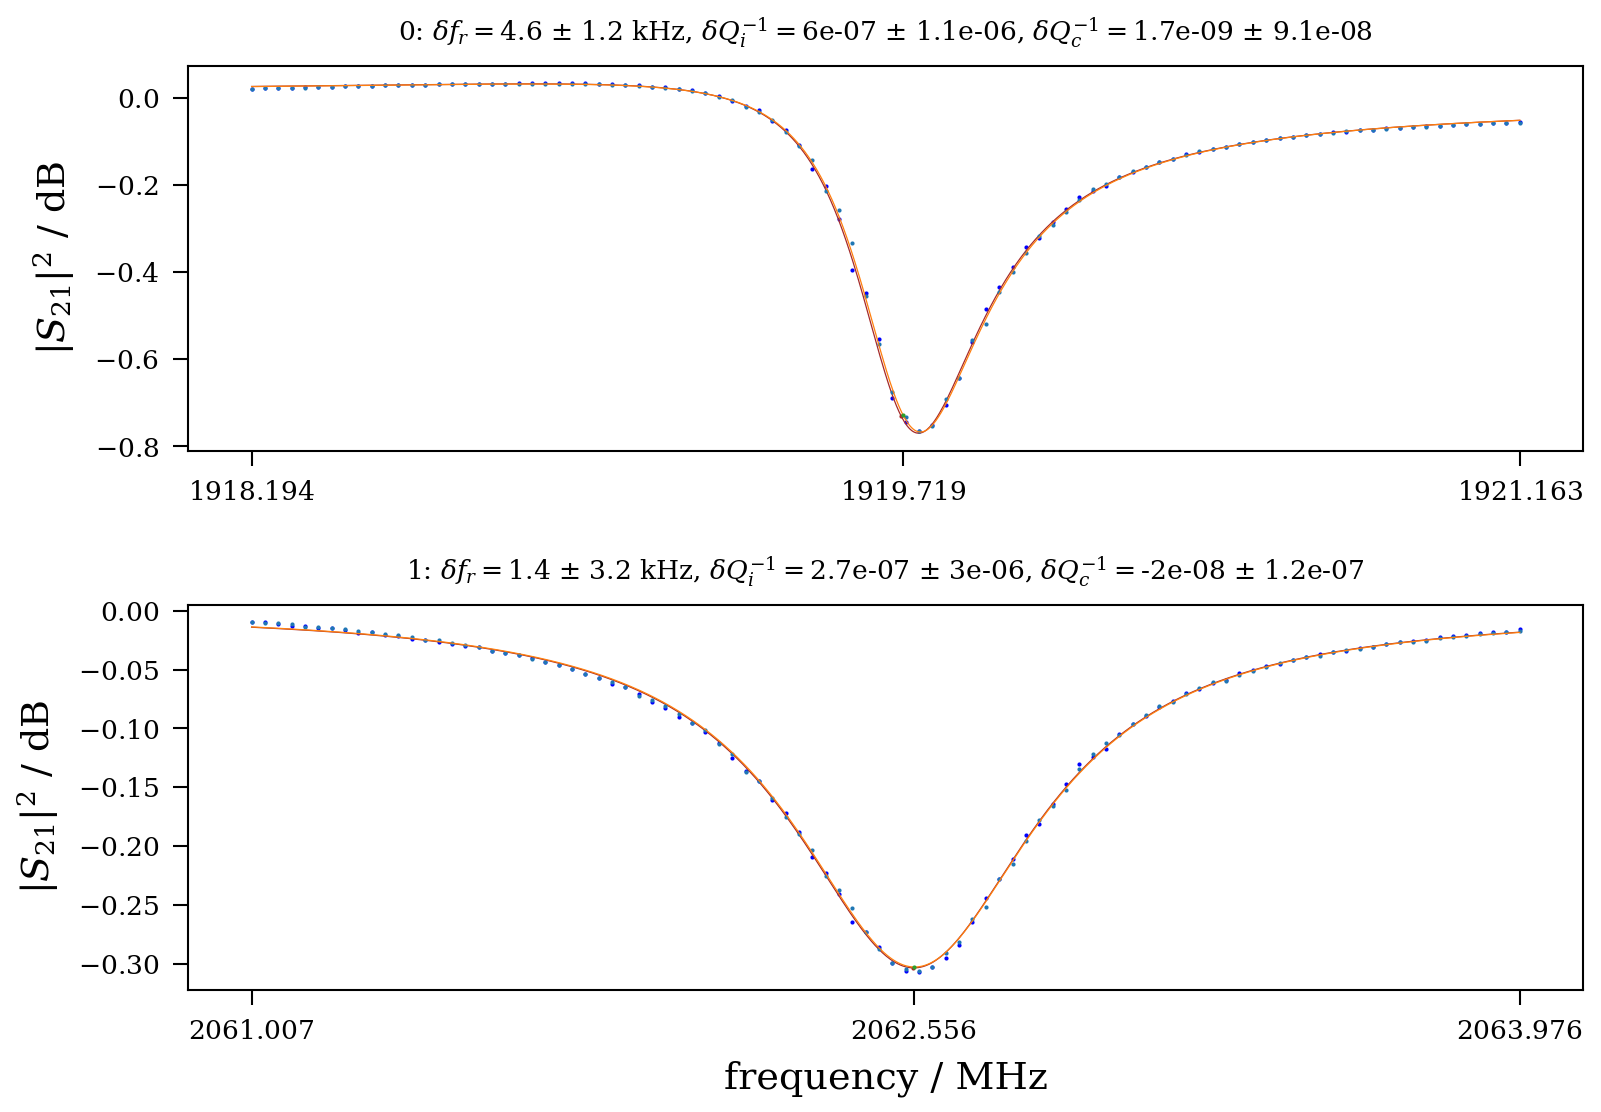

In [39]:
fig, axes = plot_3K_5K(0)

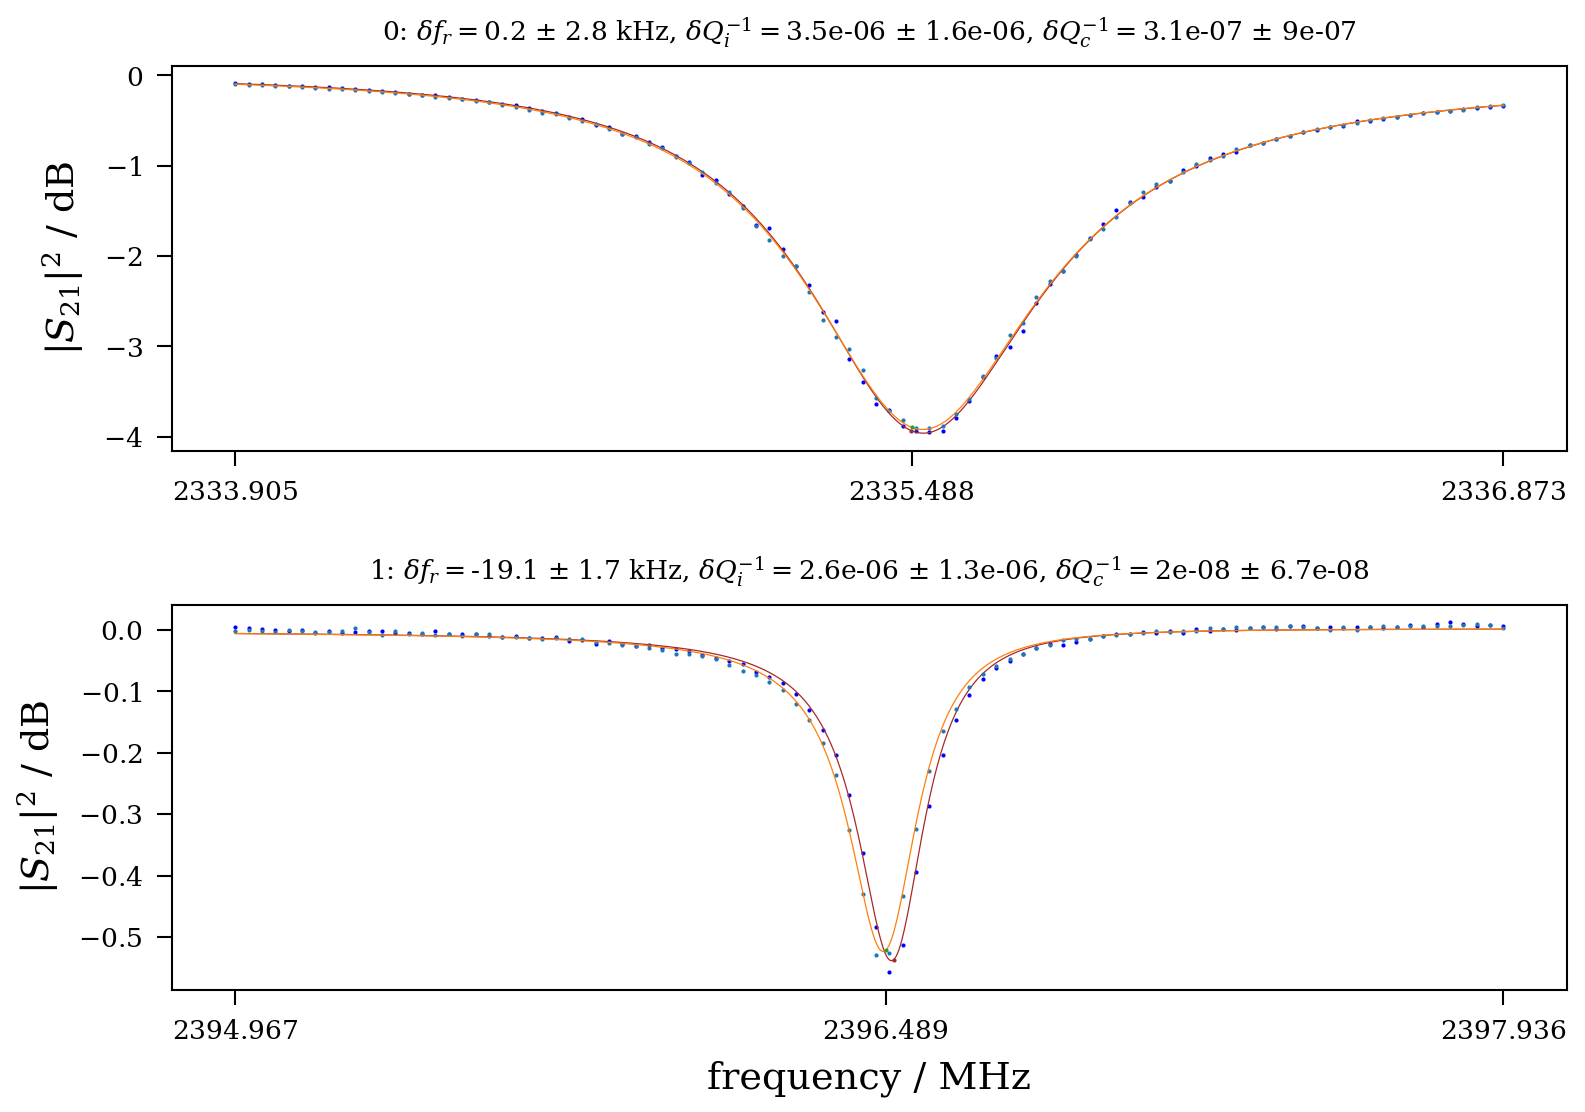

In [40]:
fig, axes = plot_3K_5K(1)
if save_example_eccosorb_response_sweeps:
    fig.savefig(save_directory + 'example_eccosorb_response_sweeps.pdf')

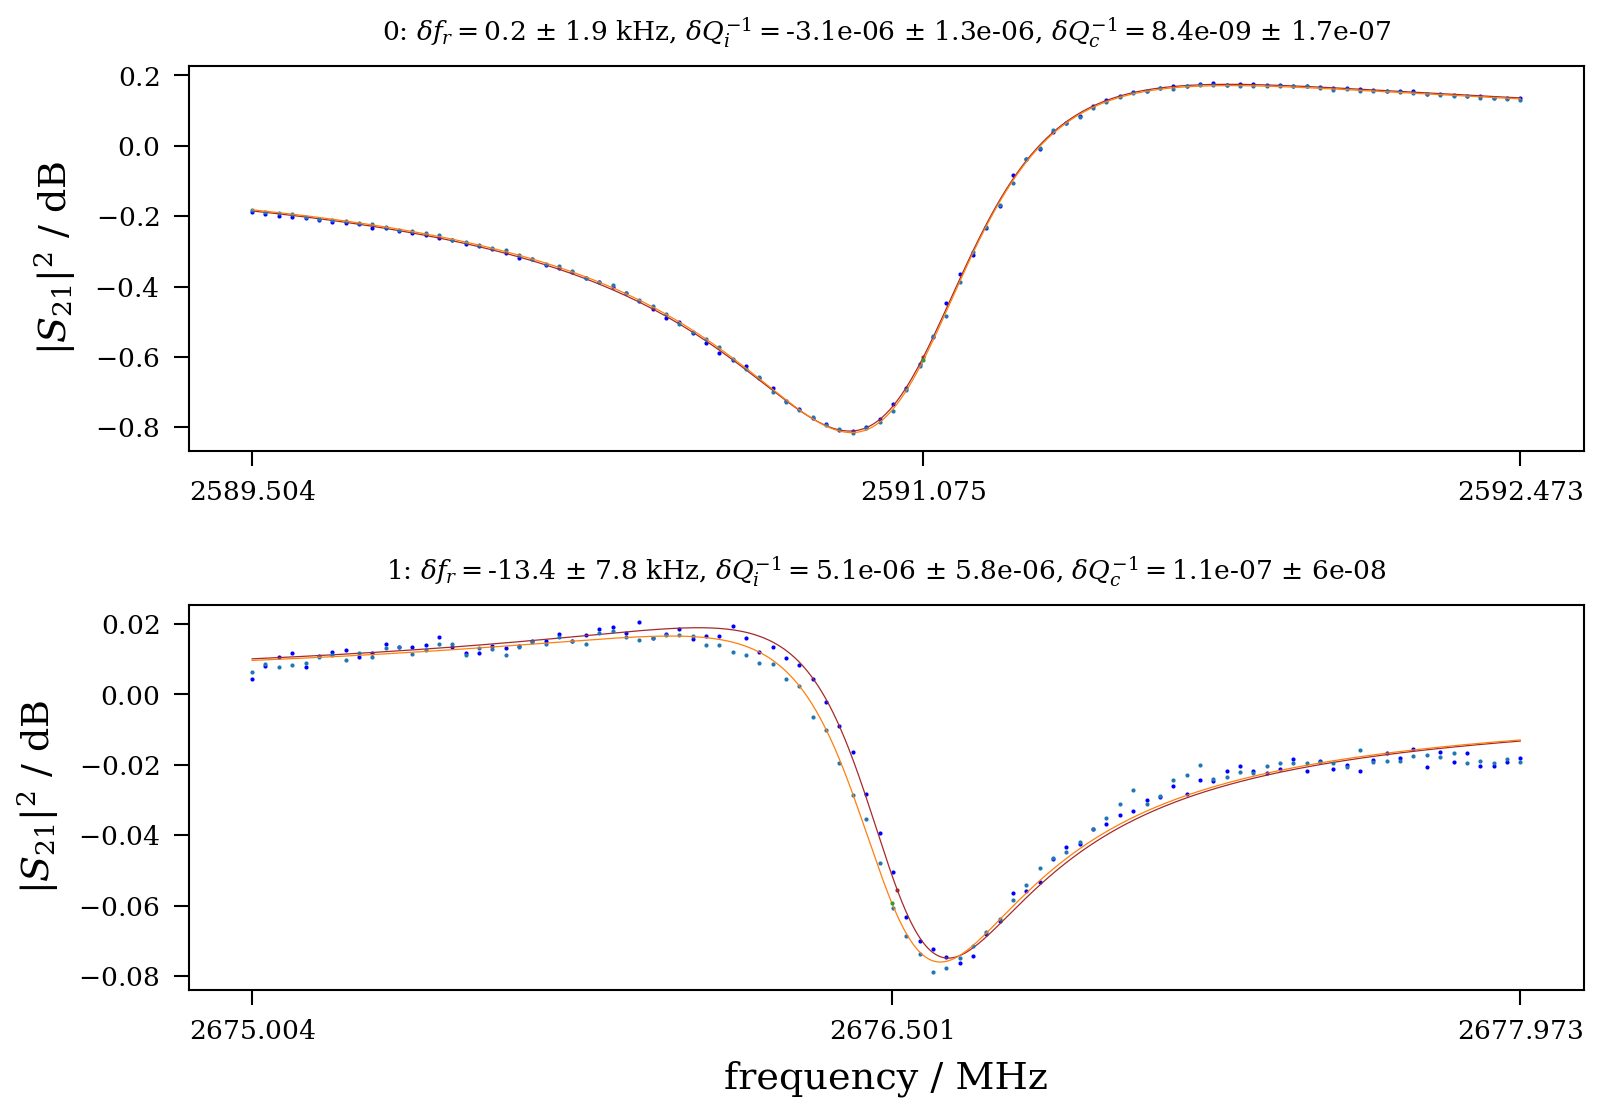

In [41]:
fig, axes = plot_3K_5K(2)
del data[2][1]

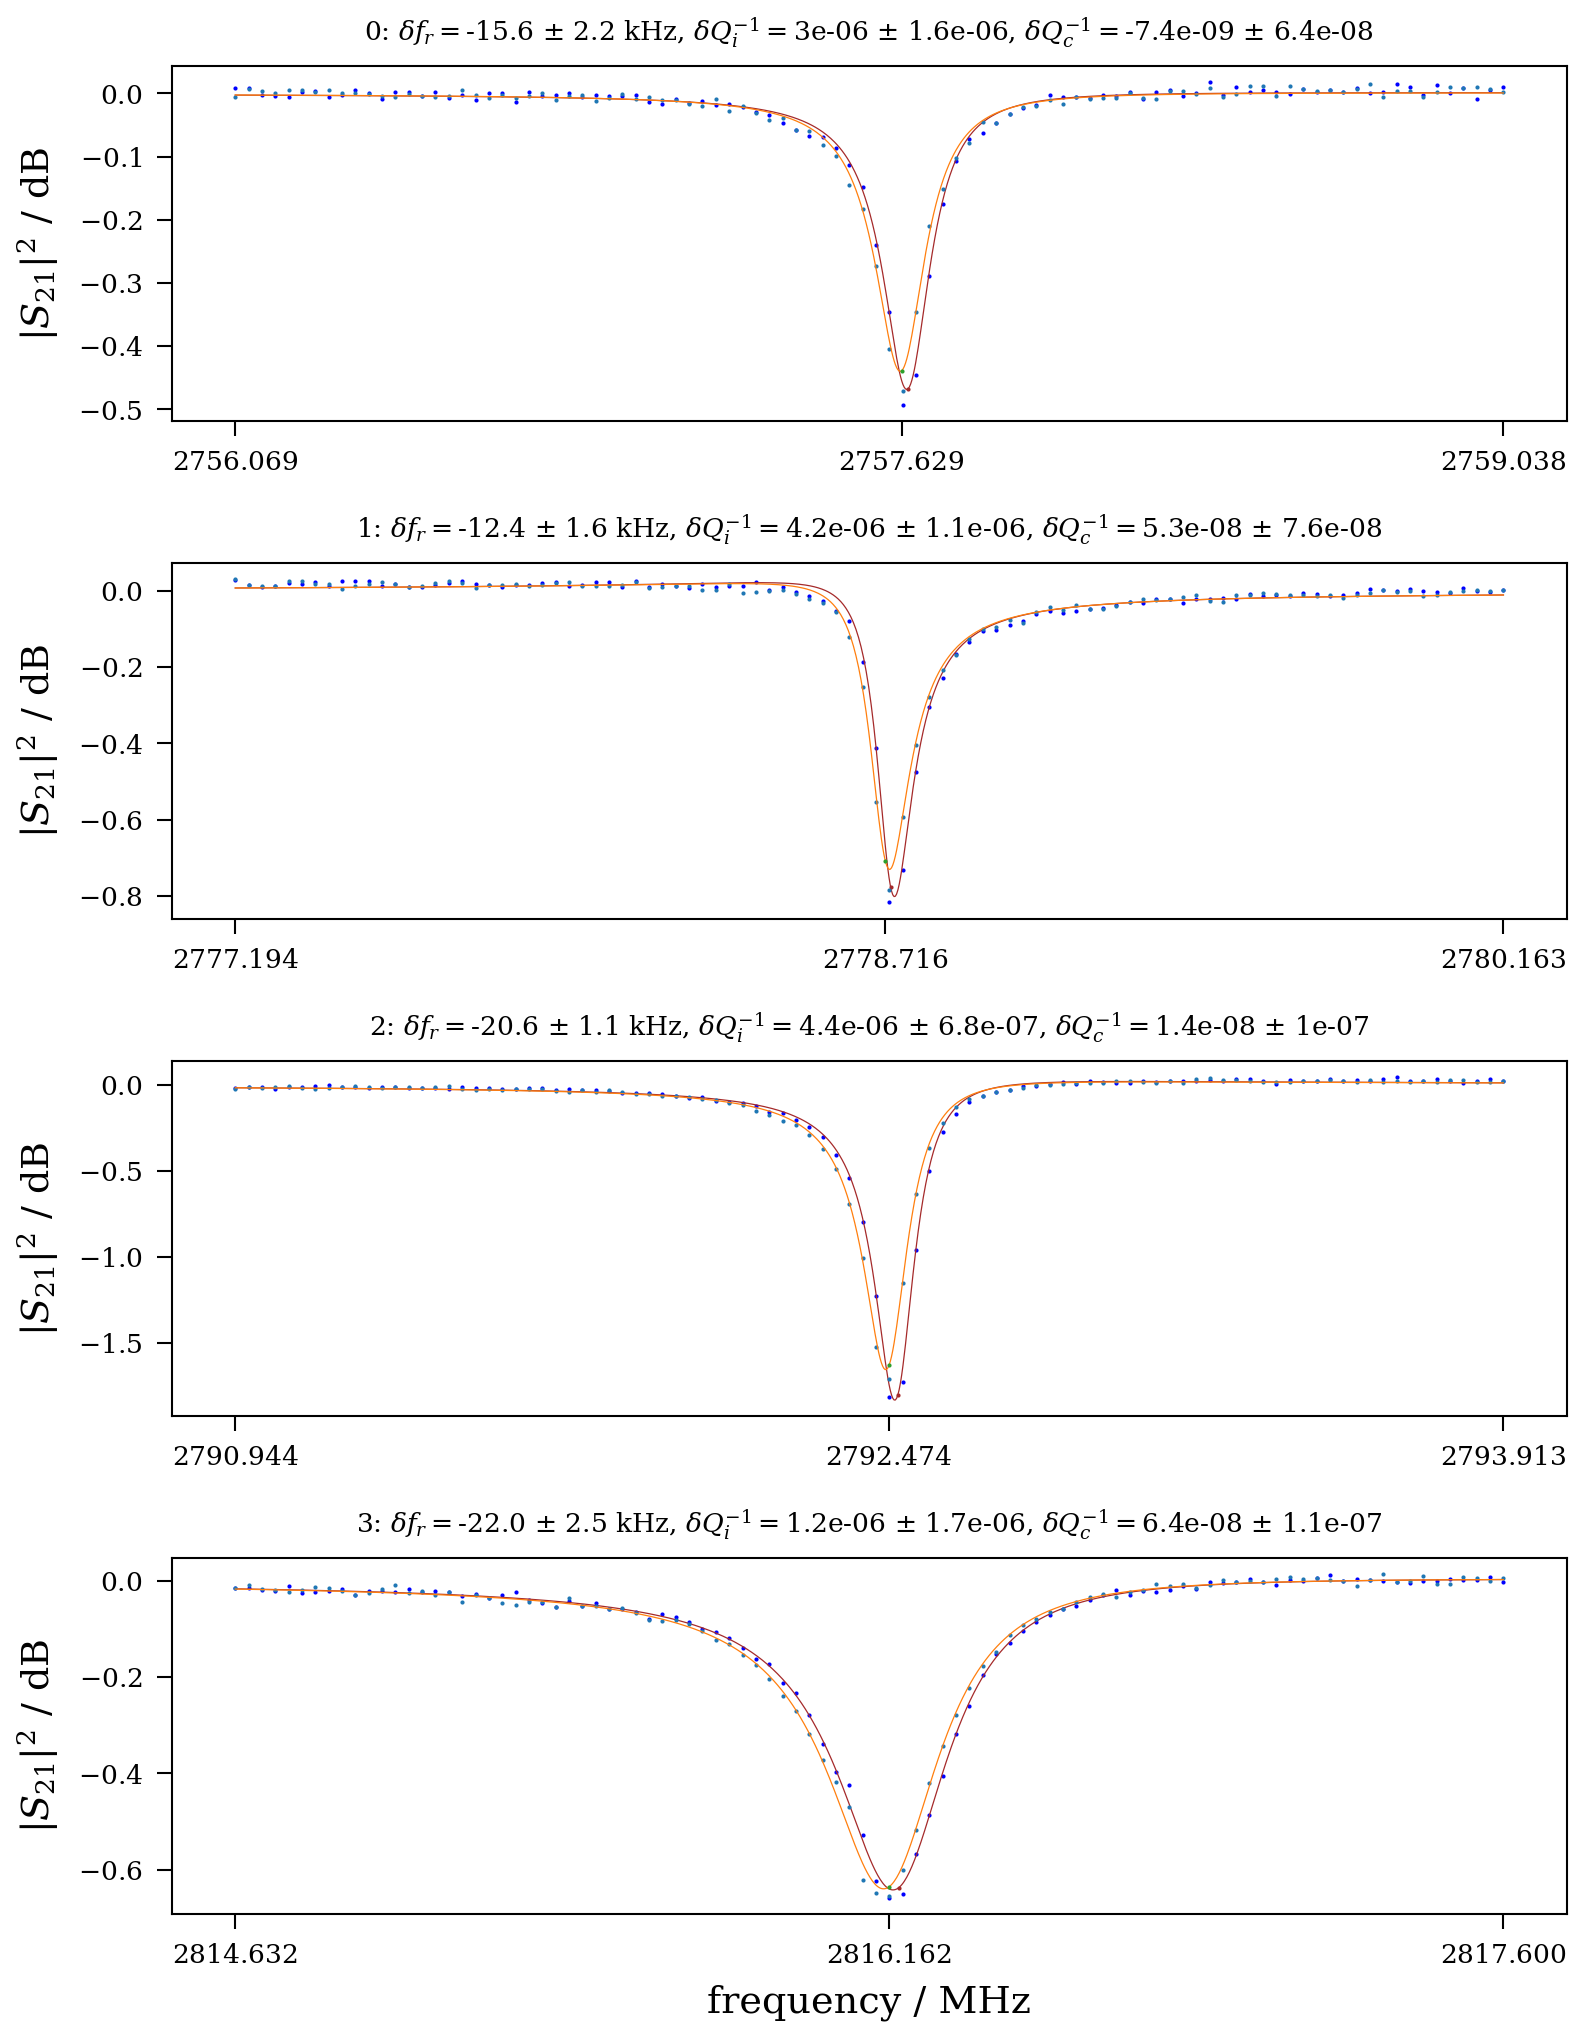

In [42]:
fig, axes = plot_3K_5K(3)

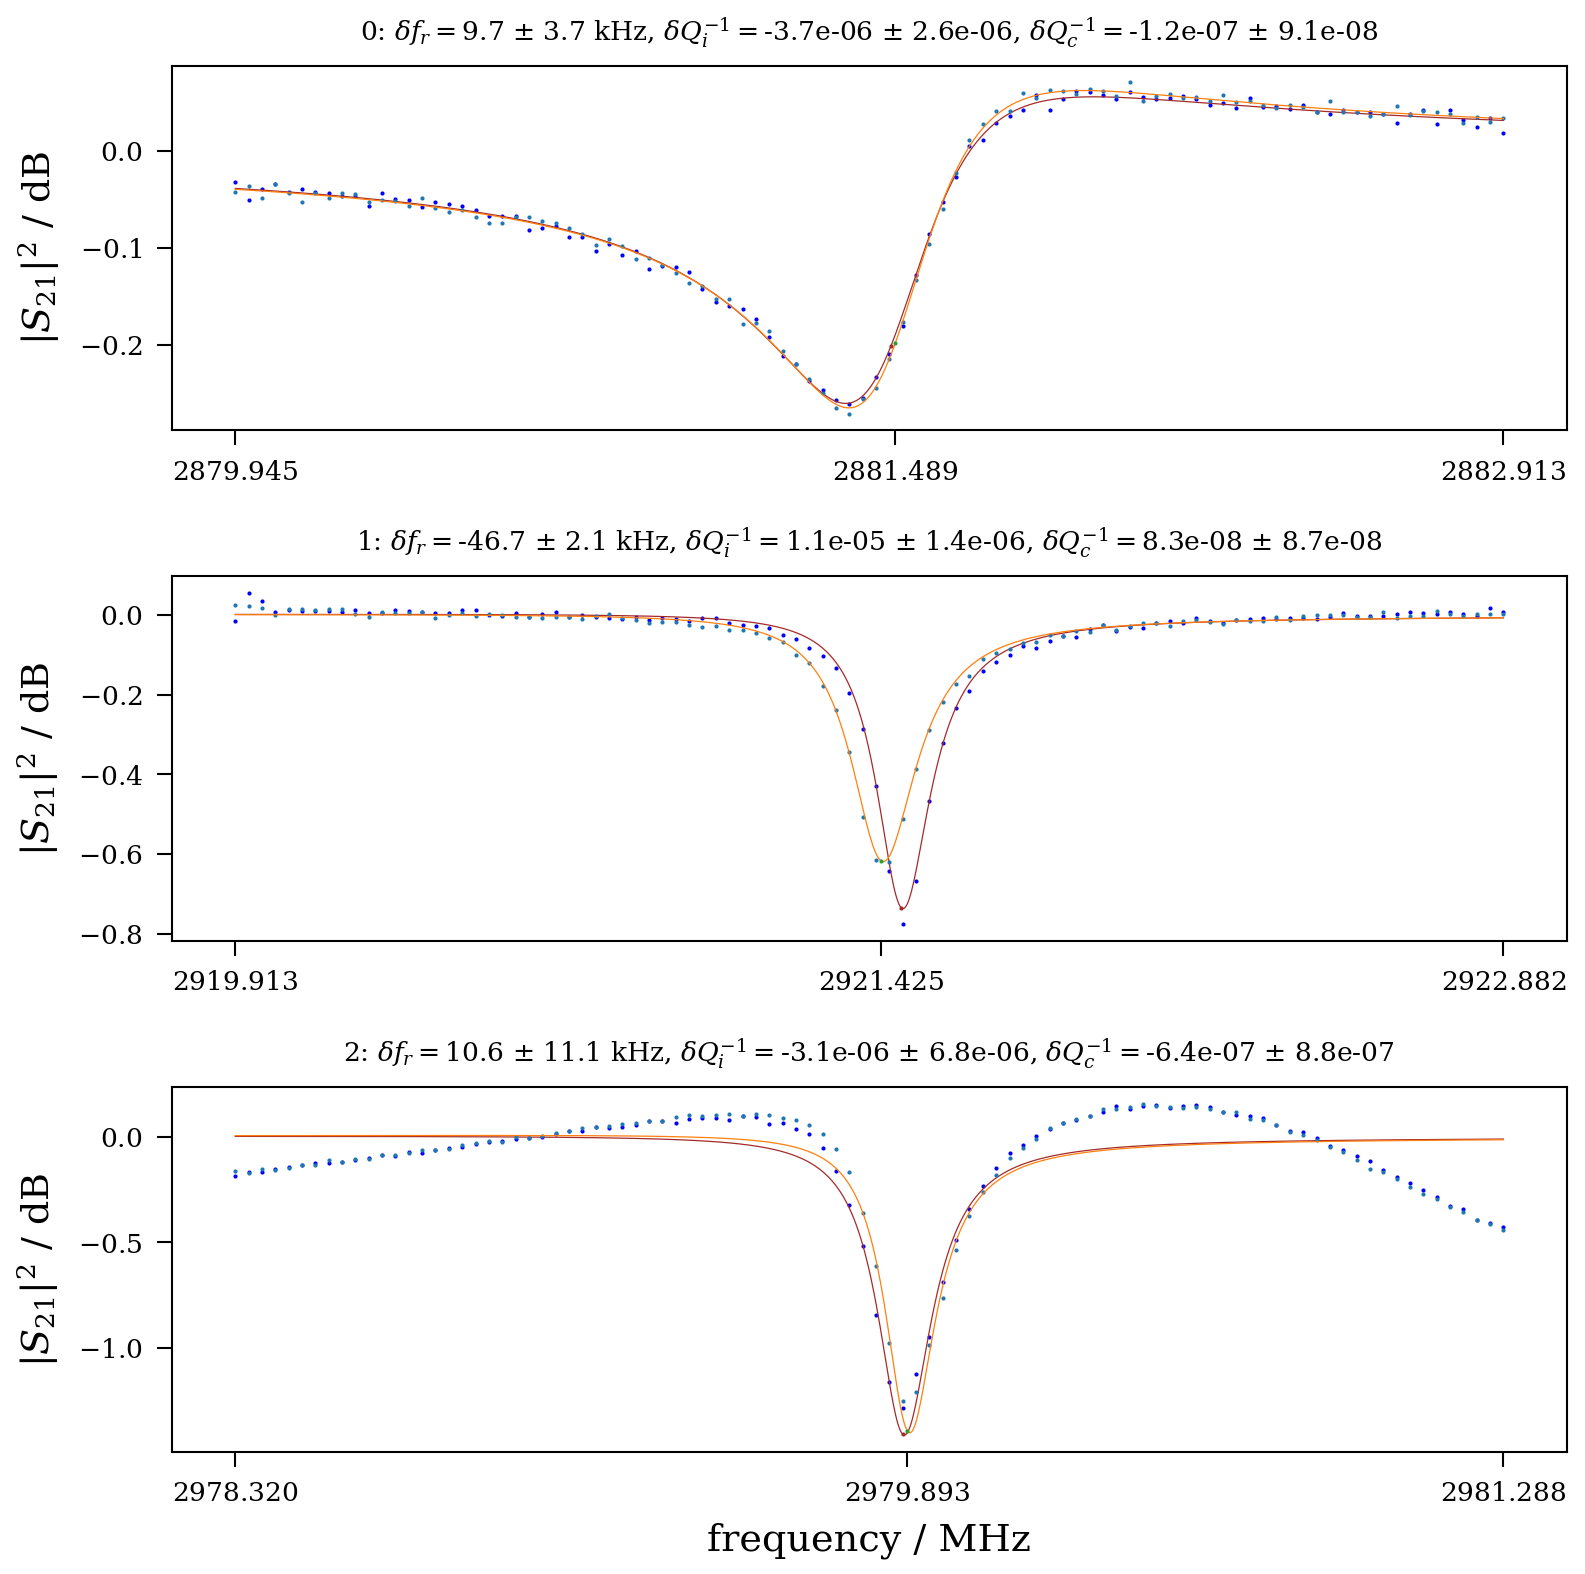

In [43]:
fig, axes = plot_3K_5K(4)
del data[4][2]

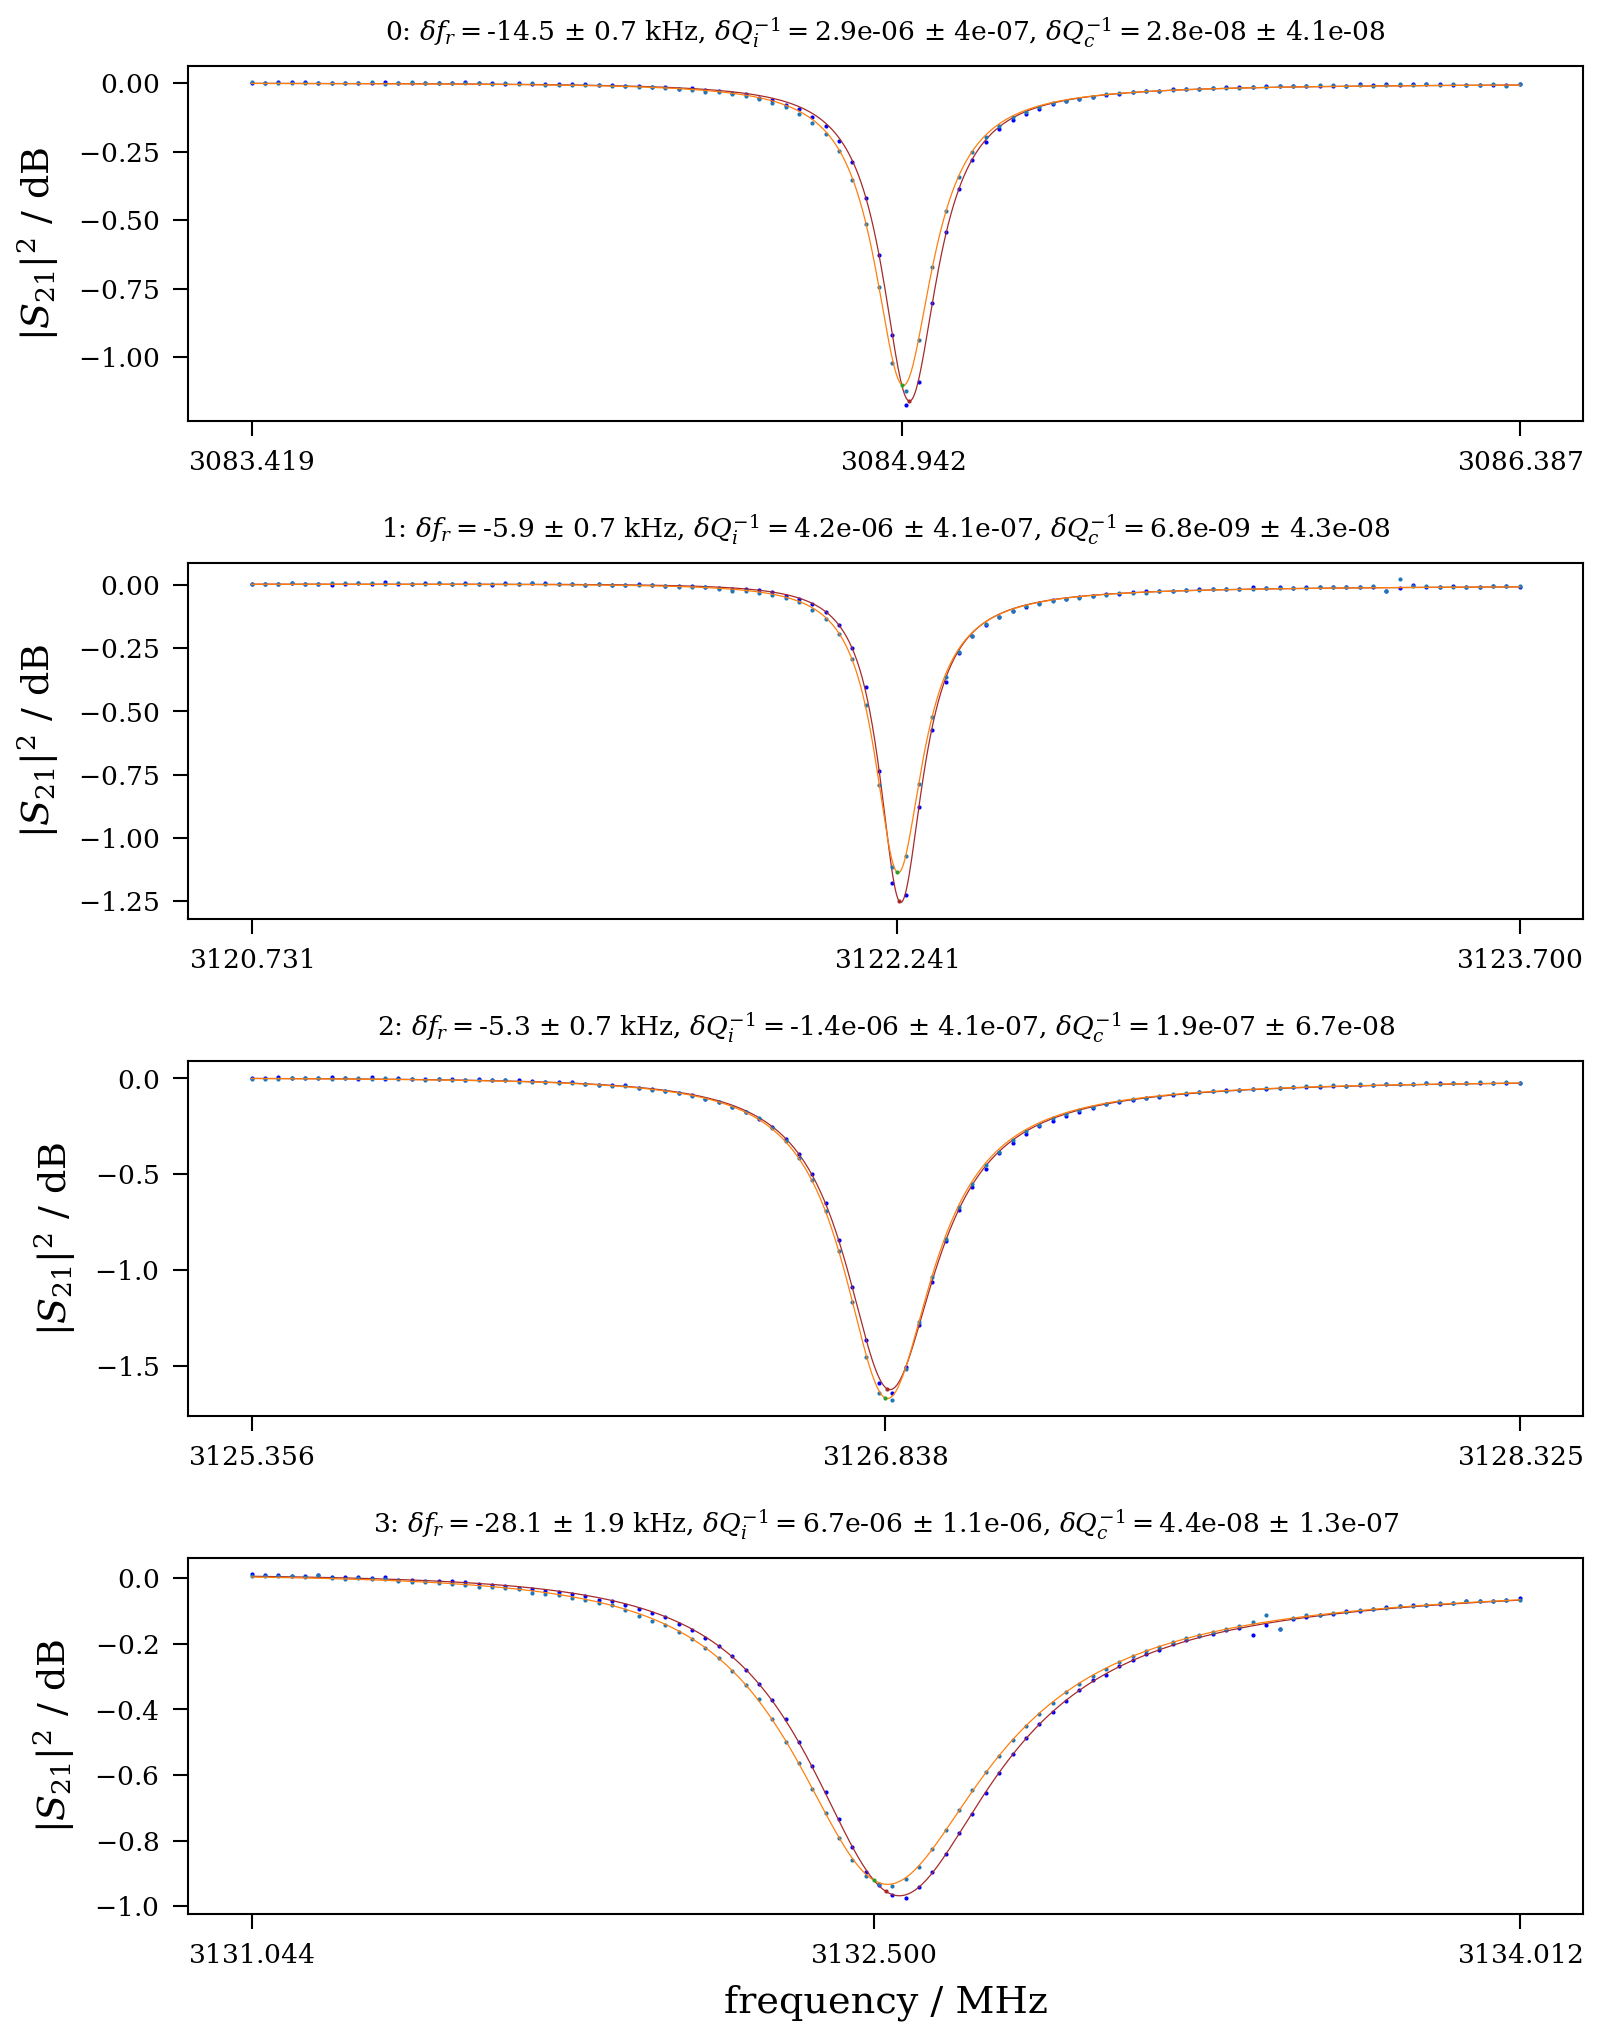

In [44]:
fig, axes = plot_3K_5K(5)

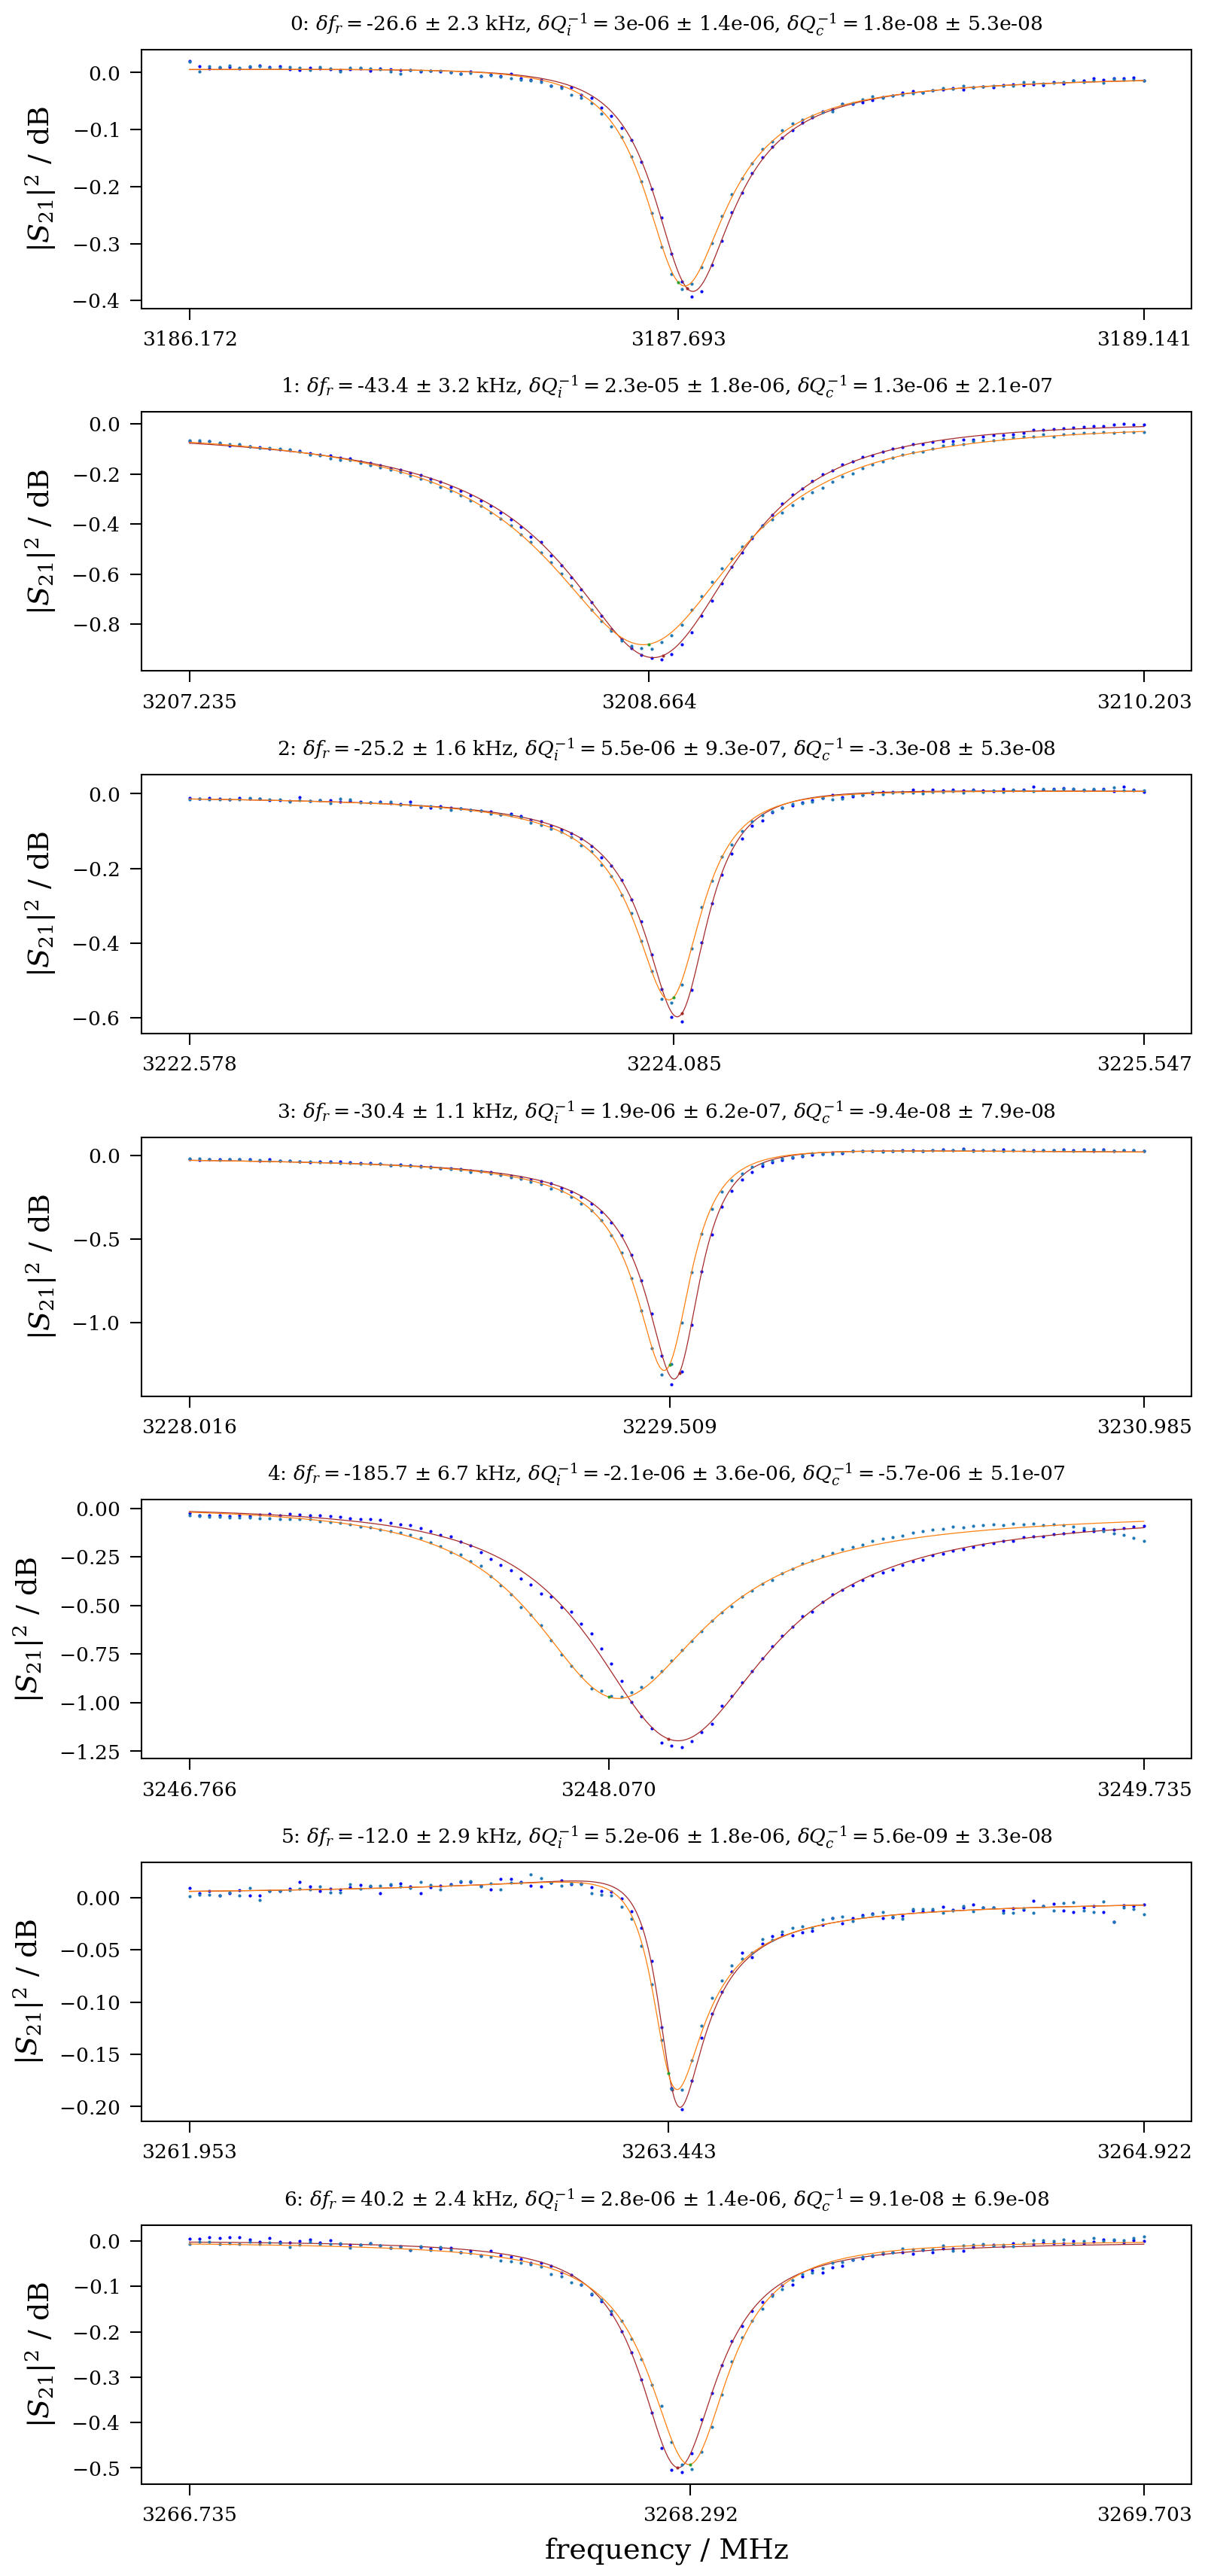

In [45]:
fig, axes = plot_3K_5K(6)
del data[6][4]

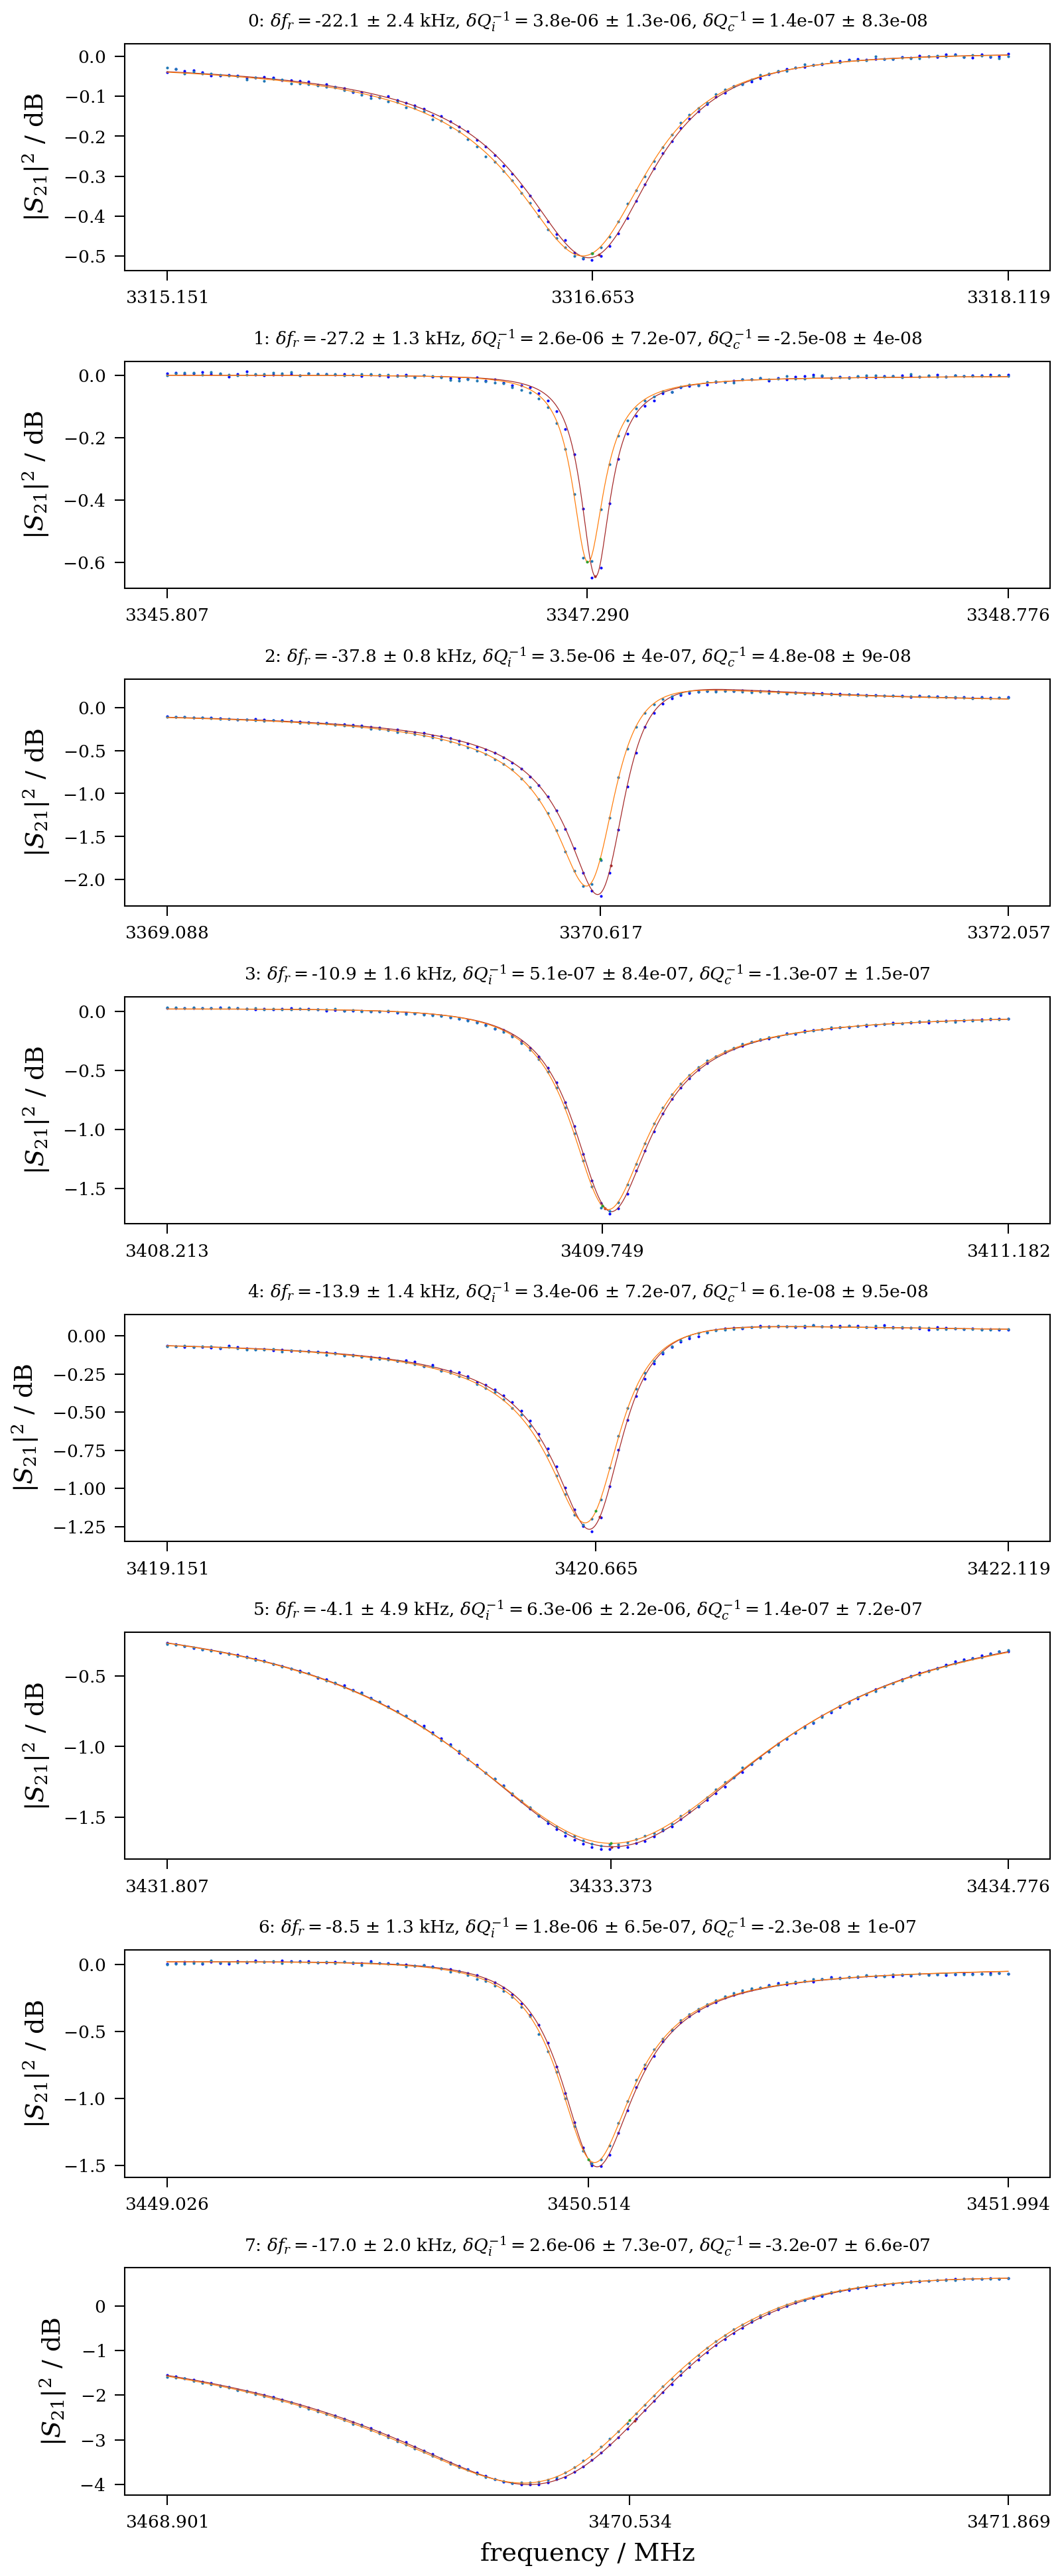

In [46]:
fig, axes = plot_3K_5K(7)

# Reduced data

In [47]:
f_nominal = 1e6 * np.concatenate([np.linspace(2542, 2634, 23),
                                  np.linspace(2664, 2756, 23),
                                  np.linspace(2786, 2878, 23),
                                  np.linspace(2908, 3000, 23)])

# Real and fake are determined from ...
f_fake = 1e6 * np.array([
    1744, 1772, 1920, 2062, 2186, 2240, 2335, 2591, 2872, 3248, 3433, 3850, 3922
])

# New row means a gap of at least 20 MHz
f_real = 1e6 * np.array([
    2396,
    2676,
    2757,
    2778, 2792, 2805, 2806, 2816, 
    2881, 2892, 
    2921, 2931, 2944, 2946, 2955, 2958, 2961, 2965, 2980, 2982, 2995, 2998, 3001,
    3062, 3064, 3066, 3078, 3081, 3085, 3088, 3092, 3093, 3096, 3097, 3098, 3122, 3127, 3132, 3139, 3149,
    3169, 3188,
    3209, 3224, 3229,
    3251, 3263, 3268, 3277, 3278, 3279, 3293,
    3316, 3325, 3327,
    3347,
    3371,
    3398, 3405, 3410, 3415, 3421,
    3442, 3451, 3456, 3470
])

In [17]:
num_good_channels = sum([len(v) for v in data.values()])
print("Using {:d} resonators for analysis".format(num_good_channels))

Using 29 resonators for analysis


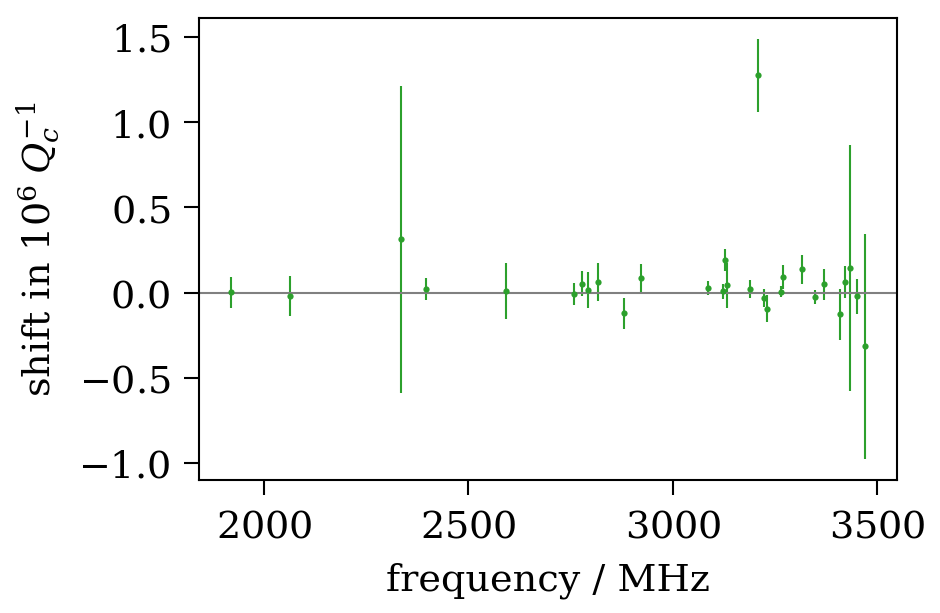

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / MHz')
ax.set_ylabel('shift in $10^{6} \; Q_c^{-1}$')
x_scale = 1e-6
y_scale = 1e6
ax.axhline(0, color='gray')
for band_index, band_data in data.items():
    for number, number_data in band_data.items():
         ax.errorbar(x_scale * number_data['f_0'],
                     y_scale * number_data['dloss_c'],
                     yerr=y_scale * number_data['dloss_c_error'],
                     linestyle='none', marker='.', color='C2')

(-60, 50)

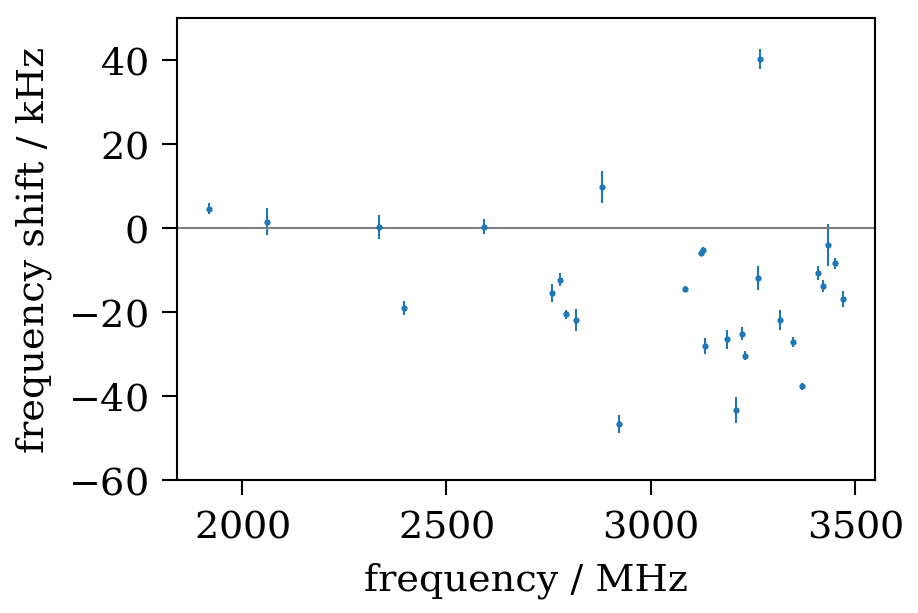

In [19]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / MHz')
ax.set_ylabel('frequency shift / kHz')
x_scale = 1e-6
y_scale = 1e-3
ax.axhline(0, color='gray')
for band_index, band_data in data.items():
    for number, number_data in band_data.items():
         ax.errorbar(x_scale * number_data['f_0'],
                     y_scale * number_data['df'],
                     yerr=y_scale * number_data['df_error'],
                    linestyle='none', marker='.', color='C0')
ax.set_ylim(-60, 50)

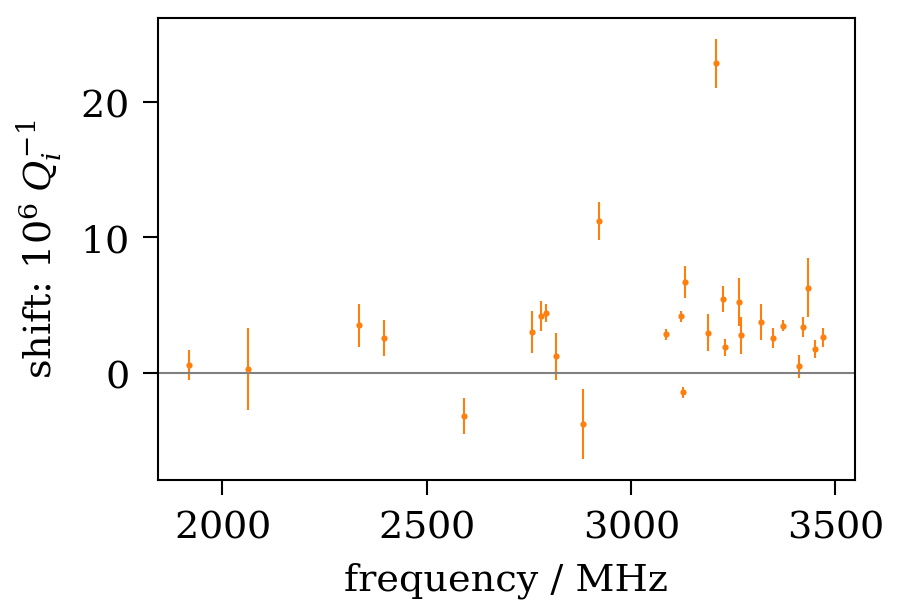

In [20]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / MHz')
ax.set_ylabel('shift: $10^{6} \; Q_i^{-1}$')
x_scale = 1e-6
y_scale = 1e6
ax.axhline(0, color='gray')
for band_index, band_data in data.items():
    for number, number_data in band_data.items():
         ax.errorbar(x_scale * number_data['f_0'],
                     y_scale * number_data['dloss_i'],
                     yerr=y_scale * number_data['dloss_i_error'],
                     linestyle='none', marker='.', color='C1')
#ax.set_ylim(-60, 50)

In [30]:
all_f_0 = []
all_s = []
all_s_error = []
all_i = []
all_i_error = []
for band_index, band_data in data.items():
    for number, number_data in band_data.items():
        all_f_0.append(number_data['f_0'])
        all_s.append(-number_data['df'] / number_data['f_0'])
        all_s_error.append(number_data['df_error'] / number_data['f_0'])
        all_i.append(number_data['dloss_i'])
        all_i_error.append(number_data['dloss_i_error'])
all_f_0 = np.array(all_f_0)
all_s = np.array(all_s)
all_s_error = np.array(all_s_error)
all_i = np.array(all_i)
all_i_error = np.array(all_i_error)

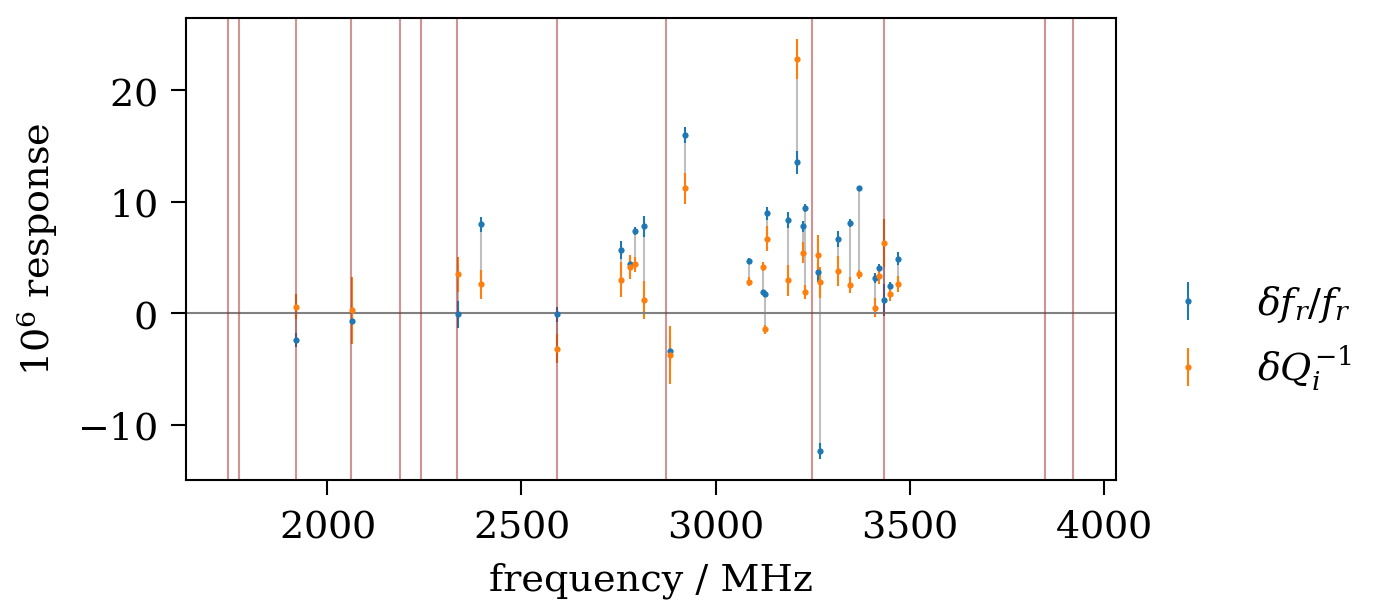

In [49]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xlabel('frequency / MHz')
ax.set_ylabel('$10^6$ response')
x_scale = 1e-6
y_scale = 1e6
ax.axhline(0, color='gray')
for f in f_fake:
    ax.axvline(x_scale * f, color='brown', alpha=0.5)
    
for f_0, s, i in zip(all_f_0, all_s, all_i):
    ax.plot(2 * [x_scale * f_0],
            [y_scale * s, y_scale * i],
            linestyle='-', color='gray', alpha=0.5, zorder=0)
ax.errorbar(x_scale * all_f_0,
            y_scale * all_s,
            yerr=y_scale * all_s_error,
            label='$\delta f_r / f_r$',
            linestyle='none', marker='.', color='C0')
ax.errorbar(x_scale * all_f_0,
            y_scale * all_i,
            label='$\delta Q_i^{-1}$',
            yerr=y_scale * all_i_error,
            linestyle='none', marker='.', color='C1')
ax.legend(bbox_to_anchor=(1, 0.5))

if save_all_eccosorb_response:
    fig.savefig(save_directory + 'all_eccosorb_response.pdf')

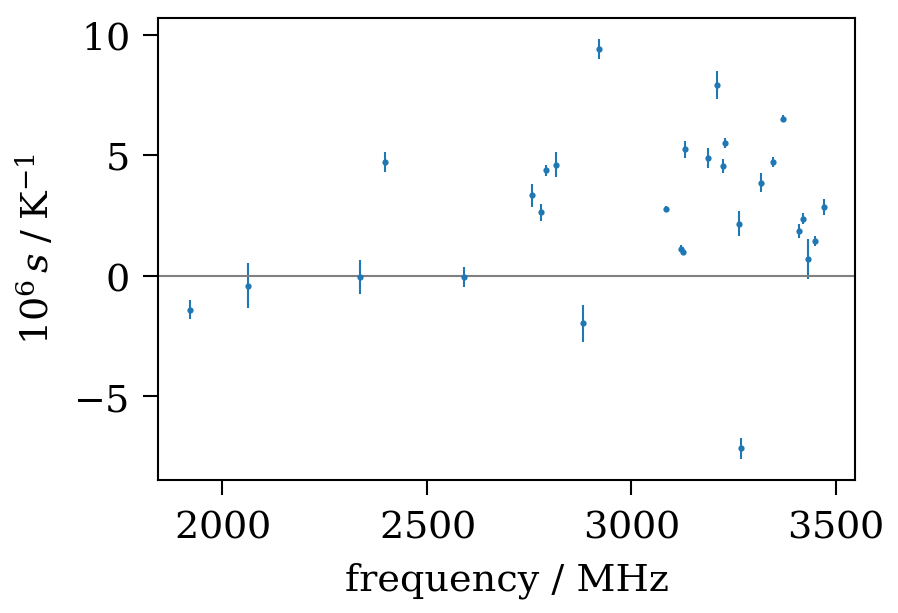

In [22]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / MHz')
ax.set_ylabel('$10^6 \, s \; / \; \mathrm{K}^{-1}$')
x_scale = 1e-6
y_scale = 1e6
ax.axhline(0, color='gray')
for band_index, band_data in data.items():
    for number, number_data in band_data.items():
        s = -number_data['df'] / number_data['f_0']
        s_per_K = s / number_data['dT']
        s_error = number_data['df_error'] / number_data['f_0']
        s_per_K_error = s_error / number_data['dT']
        ax.errorbar(x_scale * number_data['f_0'],
                    y_scale * s_per_K,
                    yerr=y_scale * s_per_K_error,
                    linestyle='none', marker='.', color='C0')

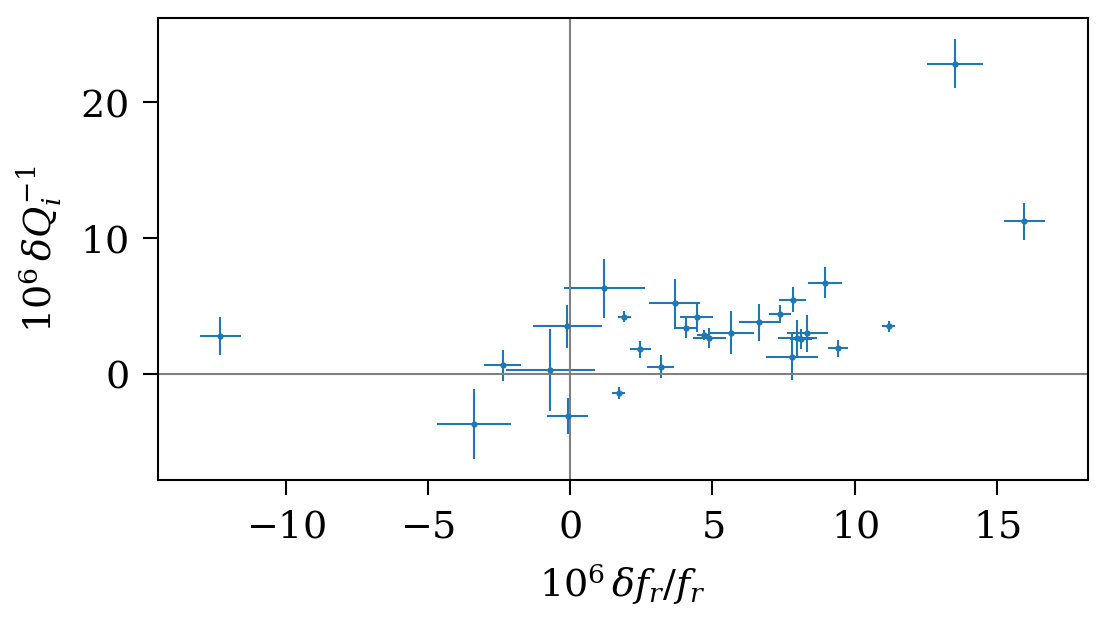

In [23]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xlabel('$10^6 \, \delta f_r / f_r$')
ax.set_ylabel('$10^6 \, \delta Q_i^{-1}$')
x_scale = 1e6
y_scale = 1e6
ax.axhline(0, color='gray')
ax.axvline(0, color='gray')
for band_index, band_data in data.items():
    for number, number_data in band_data.items():
        s = -number_data['df'] / number_data['f_0']
        s_error = number_data['df_error'] / number_data['f_0']
        i = number_data['dloss_i']
        i_error = number_data['dloss_i_error']
        ax.errorbar(x_scale * s, y_scale * i, 
                    xerr=x_scale * s_error, yerr=y_scale * i_error,
                    marker='.', color='C0')